In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import csr_matrix
import os
import sys
sys.path.append("/data/dyw/mcmcbmm/hkstools")
from hksimulation.Simulation_Branch_HP import Simulation_Branch_HP
from Initialization_Cluster_Basis import Initialization_Cluster_Basis
from Learning_Cluster_Basis import Learning_Cluster_Basis
from Estimate_Weight import Estimate_Weight
from Loglike_Basis import Loglike_Basis
from DistanceSum_MPP import DistanceSum_MPP
from Kernel_Integration import Kernel_Integration
from hksimulation.Kernel import Kernel


In [ ]:
class hksmodel():
    def __init__(self,Seqs,base_init,A_init,landmarks,ClusterNum):
        self.Seqs = Seqs
        self.base = base_init
        self.A = A_init
        self.landmarks = landmarks
        self.clusternum = ClusterNum
        self.model = None  # Initialize model as None
    
    def Initialization_Cluster_Basis(self, baseType=None, bandwidth=None, landmark=None):        
        N = len(self.Seqs)
        D = np.zeros(N)
        for i in range(N):
            D[i] = np.max(self.Seqs[i]['Mark'])
        D = int(np.max(D))+1
        model = {'K': self.ClusterNum, 'D': D}
        #如果只传入 Seqs 和 ClusterNum，则使用默认的高斯核，计算标准差和最大时间以初始化模型。
        if baseType is None and bandwidth is None and landmark is None:
            sigma = np.zeros(N)
            Tmax = np.zeros(N)

            for i in range(N):
                sigma[i] = ((4 * np.std(self.Seqs[i]['Time'])**5) / (3 * len(self.Seqs[i]['Time'])))**0.2
                Tmax[i] = self.Seqs[i]['Time'][-1] + np.finfo(float).eps
            Tmax = np.mean(Tmax)

            model['kernel'] = 'gauss'#核函数类型
            model['w'] = np.mean(sigma)#带宽
            model['landmark'] = model['w'] * np.arange(0, np.ceil(Tmax / model['w']))#地标
            
        #如果传入更多参数，模型将根据这些参数进行初始化
        # 当 baseType 被提供，但 bandwidth 和 landmark 未提供时
        elif baseType is not None and bandwidth is None and landmark is None:
            model['kernel'] = baseType
            model['w'] = 1
            model['landmark'] = 0
        # 当 baseType 和 bandwidth 被提供，但 landmark 未提供时
        elif baseType is not None and bandwidth is not None and landmark is None:
            model['kernel'] = baseType
            model['w'] = bandwidth
            model['landmark'] = 0
        # 当所有参数都被提供时，这是最灵活的情况，允许用户完全自定义模型的初始化
        else:
            model['kernel'] = baseType if baseType is not None else 'gauss'
            model['w'] = bandwidth if bandwidth is not None else 1
            model['landmark'] = landmark if landmark is not None else 0

        model['alpha'] = 1
        M = len(model['landmark'])
        model['beta'] = np.ones((D, M, model['K'], D)) / (M * D**2)

        model['b'] = np.ones((D, model['K'])) / D

        
        # Initialize label and responsibility randomly
        label = np.ceil(model['K'] * np.random.rand(1, N)).astype(int)
        model['label']=label
        model['R'] = csr_matrix((np.ones(N), (np.arange(N), label.flatten()-1)), shape=(N, model['K'])).toarray()


    def Loglike_Basis(self, alg):
        Aest = self.model['beta']#A
        muest = self.model['b']#mu
        Loglikes = [] 

        for c in range(len(self.Seqs)):
            Time = self.Seqs[c]['Time']
            Event = self.Seqs[c]['Mark']
            Event_int = Event.astype(int) if isinstance(Event, np.ndarray) else int(Event)
            Tstart = self.Seqs[c]['Start']

            if not alg['Tmax']:
                Tstop = self.Seqs[c]['Stop']
            else:
                Tstop = alg['Tmax']
                indt = Time < alg['Tmax']
                Time = Time[indt]
                Event = Event[indt]

            dT = Tstop - Time
            GK = Kernel_Integration(dT, self.model)
            

            Nc = len(Time)
            Loglike = 0
            for i in range(Nc):
                ui = Event[i]
                ti = Time[i]
                ui_int = ui.astype(int) if isinstance(ui, np.ndarray) else int(ui)
                lambdai = muest[ui_int]#基于当前模型参数的条件强度函数，给定历史事件，该事件发生的概率
                if i > 0:
                    tj = Time[:i]
                    uj = Event[:i]
                    uj_int = uj.astype(int) if isinstance(uj, np.ndarray) else int(uj)
                    ui_int = ui.astype(int) if isinstance(ui, np.ndarray) else int(ui)
                    dt = ti - tj
                    gij = Kernel(dt, self.model)
                    auiuj = Aest[uj_int, :,:, ui_int]
                    pij = np.repeat(gij[:, :, np.newaxis], 2, axis=2)* auiuj
                    #pij = auiuj * gij
                    lambdai = lambdai + np.sum(pij, axis=(0,1)).reshape(1,-1)#np.sum(pij)

                Loglike = Loglike - np.log(lambdai)
            
            Loglike = Loglike + (Tstop - Tstart) * np.sum(muest)
            GK_reshape=np.repeat(np.repeat(GK[:, :, np.newaxis, np.newaxis], Aest.shape[2], axis=2), Aest.shape[3], axis=3)
            Loglike = Loglike + (GK_reshape * Aest[Event_int, :, :, :]).sum()

            #print(GK_reshape[0,0,:,:])
            #print(np.repeat(np.repeat(GK[:, :, np.newaxis, np.newaxis], Aest.shape[2], axis=2), Aest.shape[3], axis=3).shape)
            # print(Aest.shape)

            Loglikes.append(-Loglike)

        return Loglikes
    def update_model(self):
        pass

In [18]:
#1. 参数设置
options = {
    'N': 100, 'Nmax': 100, 'Tmax': 50, 'tstep': 0.1,
    'dt': [0.1], 'M': 250, 'GenerationNum': 10
}
D = 3
K = 2
nTest = 5
nSeg = 5
nNum = options['N'] / nSeg


In [19]:
#2. 霍克斯过程的模拟（通过一个分支过程近似地模拟霍克斯过程）
# First cluster: Hawkes process with exponential kernel
print('Simple exponential kernel')
para1 = {'kernel': 'exp', 'landmark': [0]}
para1['mu'] = np.random.rand(D) / D
L = len(para1['landmark'])
para1['A'] = np.zeros((D, D, L))
for l in range(1, L + 1):
    para1['A'][:, :, l - 1] = (0.7**l) * np.random.rand(D,D)

#import pdb;pdb.set_trace()
# 对每个切片应用 np.linalg.eigh
eigvals_list = []
eigvecs_list = []
for l in range(L):
    eigvals, eigvecs = np.linalg.eigh(para1['A'][:, :, l])
    eigvals_list.append(eigvals)
    eigvecs_list.append(eigvecs)

# 对所有特征值进行处理
all_eigvals = np.concatenate(eigvals_list)
max_eigval = np.max(all_eigvals)
#import pdb;pdb.set_trace()
# 使用最大特征值进行归一化
para1['A'] = 0.5 * para1['A'] / max_eigval
para1['w'] = 0.5

Seqs1 = Simulation_Branch_HP(para1, options)


########################################################################################

# Second cluster: Hawkes process with Gaussian kernel
print('Complicated gaussian kernel')
para2 = {'kernel': 'gauss', 'landmark': np.arange(0, 13, 3)}
para2['mu'] = np.random.rand(D) / D
L = len(para2['landmark'])
para2['A'] = np.zeros((D, D, L))
for l in range(1, L + 1):
    para2['A'][:, :, l - 1] = (0.9**l) * np.random.rand(D,D)
para2['A'] = 0.25 * para2['A'] / np.max(np.abs(np.linalg.eigh(np.sum(para2['A'], axis=2))[0]))
para2['A'] = np.reshape(para2['A'], (D, L, D))
#import pdb;pdb.set_trace()
para2['w'] = 1
Seqs2 = Simulation_Branch_HP(para2, options)
SeqsMix = Seqs1 + Seqs2
#import pdb;pdb.set_trace()

# Ground truth: the similarity matrix of event sequences.
# GT[i, j] = 1 if the sequence i and the sequence j belong to the same cluster


GT = np.block([[np.ones((options['N'], options['N'])),  np.zeros((options['N'], options['N']))],
               [ np.zeros((options['N'], options['N'])), np.ones((options['N'], options['N']))]])


Simple exponential kernel
#seq=10/100, #event=19
#seq=20/100, #event=15
#seq=30/100, #event=26
#seq=40/100, #event=16
#seq=50/100, #event=43
#seq=60/100, #event=28
#seq=70/100, #event=24
#seq=80/100, #event=38
#seq=90/100, #event=26
#seq=100/100, #event=25
Complicated gaussian kernel
#seq=10/100, #event=43
#seq=20/100, #event=51


/data/dyw/mcmcbmm/hkstools/hksimulation/Kernel.py:31: RuntimeWarning: overflow encountered in square
  g = np.exp(-(distance**2) / (2 * para['w']**2)) / (np.sqrt(2 * np.pi) * para['w'])


#seq=30/100, #event=39
#seq=40/100, #event=60
#seq=50/100, #event=46
#seq=60/100, #event=44
#seq=70/100, #event=36
#seq=80/100, #event=55
#seq=90/100, #event=35
#seq=100/100, #event=53


In [20]:
# Learning a mixture model of Hawkes processes
# initialize
model = Initialization_Cluster_Basis(SeqsMix, 2)
alg = {'outer': 8, 'rho': 0.1, 'inner': 5, 'thres': 1e-5, 'Tmax': []}#'inner': 5

model = Learning_Cluster_Basis(SeqsMix, model, alg)

Loglikes=Loglike_Basis(SeqsMix, model, alg)

Inner= 0, Obj=32705.02381934272, RelErr=0.4424002957060471
Inner= 1, Obj=26022.112634207508, RelErr=0.07901749532678522
Inner= 2, Obj=26025.457598616027, RelErr=0.07298666200031936
Inner= 3, Obj=26023.580114803328, RelErr=0.0682782326291291
Inner= 4, Obj=26017.22407086822, RelErr=0.06463549820885313
MixMHP: Iter=1, Obj=26017.22407086822, Time=5.672329664230347 sec
Inner= 0, Obj=26039.470666465553, RelErr=0.12656538172301507
Inner= 1, Obj=25972.836676487892, RelErr=0.096533504995391
Inner= 2, Obj=25990.747915031814, RelErr=0.08439941102947737
Inner= 3, Obj=25998.808102249855, RelErr=0.0775342401153879
Inner= 4, Obj=25999.780599295085, RelErr=0.07323055170937505
MixMHP: Iter=2, Obj=25999.780599295085, Time=11.322177410125732 sec
Inner= 0, Obj=26017.18524500157, RelErr=0.15405088859933894
Inner= 1, Obj=25632.540181072865, RelErr=0.11730709158769316
Inner= 2, Obj=25651.719750101816, RelErr=0.10574303665491687
Inner= 3, Obj=25653.2017928032, RelErr=0.09798846852697951
Inner= 4, Obj=25643.42

/data/dyw/mcmcbmm/hkstools/Learning_Cluster_Basis.py:38: RuntimeWarning: invalid value encountered in true_divide
  tmp1 = A.flatten() / model['beta'].flatten()
/data/dyw/mcmcbmm/hkstools/Learning_Cluster_Basis.py:58: RuntimeWarning: divide by zero encountered in true_divide
  AA = 1.0 / model['beta']
/data/dyw/mcmcbmm/hkstools/Learning_Cluster_Basis.py:58: RuntimeWarning: overflow encountered in true_divide
  AA = 1.0 / model['beta']


Inner= 0, Obj=22649.476415537592, RelErr=0.06064375941963815
Inner= 1, Obj=21738.60629190596, RelErr=0.05608917078982577
Inner= 2, Obj=21730.596406351564, RelErr=0.0523507174206157
Inner= 3, Obj=21723.542610112334, RelErr=0.049520277264961644
Inner= 4, Obj=21717.117372648976, RelErr=0.046878181860235395
MixMHP: Iter=6, Obj=21717.117372648976, Time=34.02935600280762 sec
Inner= 0, Obj=21751.696094995794, RelErr=0.04805406671350277
Inner= 1, Obj=21046.077283294453, RelErr=0.044958270302689854
Inner= 2, Obj=21039.475915963947, RelErr=0.042021525338567775
Inner= 3, Obj=21033.72310759706, RelErr=0.03926448970403649
Inner= 4, Obj=21028.592365547906, RelErr=0.036651617169781193
MixMHP: Iter=7, Obj=21028.592365547906, Time=39.713135957717896 sec
Inner= 0, Obj=21040.916209765117, RelErr=0.037145726976787946
Inner= 1, Obj=20494.19443025417, RelErr=0.034659570273588215
Inner= 2, Obj=20489.173799565535, RelErr=0.032439575647089394
Inner= 3, Obj=20485.080217881325, RelErr=0.03040290132540102
Inner= 

In [5]:
labels1 = np.argmax(model['R'], axis=1)

# 估计相似性矩阵
Est1 = np.zeros((len(labels1), len(labels1)), dtype=int)
for i in range(len(labels1)):
    for j in range(len(labels1)):
        if labels1[i] == labels1[j]:
            Est1[i, j] = 1
# #4. 标记点过程的距离度量学习:
# 配置了一些参数（如时间窗口大小，维度等），并用这些参数来估计权重。
# 计算序列之间的距离，并基于这些距离构建另一个估计的相似度矩阵 SimilarMat。

# Learning a distance metric of marked point processes
configure = {'M': [options['Tmax'], D], 'id': [1, 2, [1, 2]], 'tau': 1, 'W': 5, 'epoch': 10, 'lr': 1e-4}
configure, obj = Estimate_Weight(configure, SeqsMix)


epoch=1, #seq=1/200, obj=1.0085607150905306e-98, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=2/200, obj=0.007188660644552271, ||grad||=37.3071, time=0.00sec
epoch=1, #seq=3/200, obj=0.9999998493376573, ||grad||=2263.8658, time=0.00sec
epoch=1, #seq=4/200, obj=0.9062048233408285, ||grad||=3257.7522, time=0.00sec
epoch=1, #seq=5/200, obj=1.0345863792168682e-73, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=6/200, obj=8.258768145322522e-65, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=7/200, obj=0.9960953652694708, ||grad||=3172.0443, time=0.00sec
epoch=1, #seq=8/200, obj=3.451727697885248e-25, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=9/200, obj=6.012112337156194e-39, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=10/200, obj=7.469167104763377e-236, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=11/200, obj=3.1451720850442283e-146, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=12/200, obj=5.2706992090084836e-21, ||grad||=0.0000, time=0.00sec
epoch=1, #seq=13/200, obj=1.3573737206385217e-186, ||gr

In [ ]:


Dis = np.zeros((len(SeqsMix), len(SeqsMix)))
tic = time.time()
for n in range(len(SeqsMix) - 1):
    Xn = np.vstack([SeqsMix[n]['Time'], SeqsMix[n]['Mark']])#concatenate
    for m in range(n + 1, len(SeqsMix)):
        Xm = np.vstack([SeqsMix[m]['Time'], SeqsMix[m]['Mark']])

        Dis[n, m], _ = DistanceSum_MPP(Xn, Xm, configure)
toc = time.time()
Dis = Dis + Dis.T
# estimate similarity matrix
SimilarMat = np.exp(-Dis**2 / (2 * np.var(Dis)))



n:0
m:1
Xn:(2, 74)
Xm:(2, 49)
n:0
m:2
Xn:(2, 74)
Xm:(2, 61)
n:0
m:3
Xn:(2, 74)
Xm:(2, 51)
n:0
m:4
Xn:(2, 74)
Xm:(2, 52)
n:0
m:5
Xn:(2, 74)
Xm:(2, 60)
n:0
m:6
Xn:(2, 74)
Xm:(2, 63)
n:0
m:7
Xn:(2, 74)
Xm:(2, 53)
n:0
m:8
Xn:(2, 74)
Xm:(2, 60)
n:0
m:9
Xn:(2, 74)
Xm:(2, 46)
n:0
m:10
Xn:(2, 74)
Xm:(2, 63)
n:0
m:11
Xn:(2, 74)
Xm:(2, 64)
n:0
m:12
Xn:(2, 74)
Xm:(2, 66)
n:0
m:13
Xn:(2, 74)
Xm:(2, 46)
n:0
m:14
Xn:(2, 74)
Xm:(2, 50)
n:0
m:15
Xn:(2, 74)
Xm:(2, 74)
n:0
m:16
Xn:(2, 74)
Xm:(2, 48)
n:0
m:17
Xn:(2, 74)
Xm:(2, 52)
n:0
m:18
Xn:(2, 74)
Xm:(2, 27)
n:0
m:19
Xn:(2, 74)
Xm:(2, 53)
n:0
m:20
Xn:(2, 74)
Xm:(2, 50)
n:0
m:21
Xn:(2, 74)
Xm:(2, 42)
n:0
m:22
Xn:(2, 74)
Xm:(2, 53)
n:0
m:23
Xn:(2, 74)
Xm:(2, 73)
n:0
m:24
Xn:(2, 74)
Xm:(2, 73)
n:0
m:25
Xn:(2, 74)
Xm:(2, 60)
n:0
m:26
Xn:(2, 74)
Xm:(2, 45)
n:0
m:27
Xn:(2, 74)
Xm:(2, 77)
n:0
m:28
Xn:(2, 74)
Xm:(2, 41)
n:0
m:29
Xn:(2, 74)
Xm:(2, 48)
n:0
m:30
Xn:(2, 74)
Xm:(2, 43)
n:0
m:31
Xn:(2, 74)
Xm:(2, 77)
n:0
m:32
Xn:(2, 74)
Xm:(2, 44)
n:0
m:33
Xn:(2, 7

In [ ]:
import numpy as np

def purity(predict_index, real_index):
    real_num = real_index.max() + 1
    predict_num = predict_index.max() + 1
    success_cluster = 0
    for i in range(predict_num):
        tmp_count = np.zeros(real_num)
        for j in range(real_index.shape[0]):
            if (predict_index[j] == i):
                tmp_count[real_index[j]] += 1
        success_cluster += tmp_count.max()
    return success_cluster / predict_index.shape[0]   

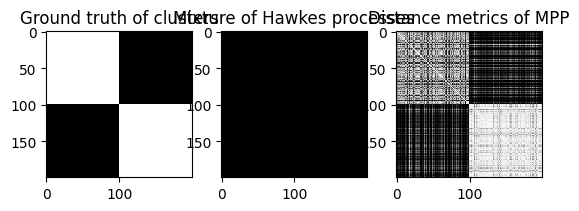

In [ ]:
# 真实聚类情况&估计结果
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(GT, cmap='gray', interpolation='none')
plt.title('Ground truth of clusters')
plt.subplot(1, 3, 2)
plt.imshow(Est1, cmap='gray', interpolation='none')
plt.title('Mixture of Hawkes processes')
plt.subplot(1, 3, 3)
plt.imshow(SimilarMat, cmap='gray', interpolation='none')
plt.title('Distance metrics of MPP')
plt.show()